In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import argparse
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from models.shiftnet_model import ShiftNetModel
from options.train_options import TrainOptions 
from models import networks
import numpy as np

In [2]:
discriminator = networks.define_D(3, 64, 'basic')
discriminator.cuda()

initialize network with normal


NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [3]:
x_np = np.random.normal(0, 1, (1, 3, 256, 256))
x_tr = torch.FloatTensor(x_np).cuda()

In [4]:
preds = discriminator(x_tr)

In [5]:
preds.shape

torch.Size([1, 1, 30, 30])

In [6]:
## CREATE MASK ALGO

In [7]:
import util
from util.util import *
from collections import namedtuple 

In [8]:
optClass = namedtuple('Options', ['fineSize'])

In [9]:
opt = optClass(fineSize=256)
opt.fineSize

256

In [10]:
%time mask = wrapper_gmask(opt)

CPU times: user 176 ms, sys: 16 ms, total: 192 ms
Wall time: 25.1 ms


/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


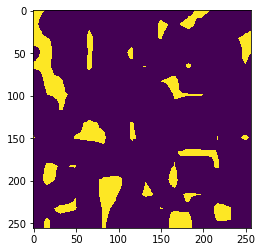

In [11]:
plt.imshow(np.squeeze(mask))

In [12]:
import skimage
from skimage.transform import resize

In [14]:
masks.shape

NameError: name 'masks' is not defined

In [ ]:
masks = []
for _ in range(1000):
    mask = wrapper_gmask(opt).cpu().numpy()
    masks.append(resize(np.squeeze(mask), (64, 64)))
masks = np.array(masks)

In [ ]:
#masks = masks.reshape((1000, -1))

In [ ]:
mean = np.mean(masks) 
masks[masks >= mean] = 1
masks[masks < mean] = 0

In [ ]:
masks.shape

In [ ]:
plt.imshow(masks[0])

In [ ]:
masks = masks.astype(np.int)
masks = masks.reshape((10000, -1))

In [ ]:
time intersection = np.matmul(masks, masks.T)

In [ ]:
intersection.max()

In [ ]:
plt.imshow(intersection)

In [ ]:
diag = np.diag(intersection)


In [ ]:
outer_add = np.add.outer(diag, diag)

In [ ]:
iou = intersection / outer_add

In [ ]:
plt.imshow(iou)

In [ ]:
np.unravel_index(np.argmin(iou), iou.shape)

In [ ]:
class OptimizerMask:
    
    def __init__(self, masks, stop_criteria=0.85):
        self.masks = masks
        self.indexes = []
        self.stop_criteria = stop_criteria
        
        
    def get_iou(self):
        intersection = np.matmul(masks, masks.T)
        diag = np.diag(intersection)
        outer_add = np.add.outer(diag, diag)
        self.iou = intersection / outer_add 
        self.shape = self.iou.shape
        
    def _is_finished(self):
        masks = self.masks[self.indexes]
        #print(masks.shape)
        masks = np.sum(masks, axis=0)
        #print(masks.shape)
        masks[masks > 0] = 1
        plt.imshow(masks.reshape((64, 64)))
        area_coverage = np.sum(masks)/np.product(masks.shape)
        #print(area_coverage)
        if area_coverage < self.stop_criteria:
            return False
        else:
            return True
        
    def mean(self):
        _mean = np.mean(np.sum(self.masks[self.indexes], axis=-1))/(64*64)
        print(_mean)
        
    def _get_next_indexes(self):
        ious = self.iou[self.indexes]
        _mean_iou = np.mean(ious, axis=0)
        idx = np.argmin(_mean_iou)
        #print(idx)
        self.indexes = np.append(self.indexes, np.argmin(_mean_iou))
        
    def _solve(self):
        self.indexes = list(np.unravel_index(np.argmin(self.iou), self.shape))
        #print(self.indexes)
        while not self._is_finished():
            self._get_next_indexes()
            
    def get_masks(self):
        masks = self.masks[self.indexes]
        full = np.ones_like(masks[0])
        left = full - np.mean(masks, axis=0)
        return np.append(masks, left).reshape((-1, 64, 64))
    
    def solve(self):
        self._solve()
        

In [ ]:
opti = OptimizerMask(masks)

In [ ]:
opti.get_iou()

In [ ]:
opti.solve()

In [ ]:
opti.mean()

In [ ]:
output = opti.get_masks()

In [ ]:
output.shape